# 1. Data Loading and Preprocessing

In [1]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.7 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load data from Yahoo Finance (Upload your CSV file)
from google.colab import drive
drive.mount('/content/drive')

# Read CSV file into DataFrame and set 'Date' as index
DJIA_path = '/content/drive/MyDrive/FINAL PROJECT/DJIA_table(train).csv'
djia_data = pd.read_csv(DJIA_path)

# Read CSV file into DataFrame and set 'Date' as index
reddit_path = '/content/drive/MyDrive/FINAL PROJECT/RedditNews(train).csv'
reddit_data = pd.read_csv(reddit_path)

# Initialize the VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity using VADER
def calculate_vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    return round(score['compound'], 3)

# Calculate sentiment scores for Reddit news
reddit_data['SentimentScore'] = reddit_data['News'].apply(calculate_vader_sentiment)

# Aggregate sentiment scores by date
sentiment_by_date = reddit_data.groupby('Date')['SentimentScore'].mean().reset_index()

# Convert date columns to a consistent format
sentiment_by_date['Date'] = pd.to_datetime(sentiment_by_date['Date'])
djia_data['Date'] = pd.to_datetime(djia_data['Date'], dayfirst=True)

# Merge the datasets on the 'Date' column
merged_data = pd.merge(djia_data, sentiment_by_date, how='inner', on='Date')

# Select required columns
final_dataset = merged_data[['Date', 'Close', 'SentimentScore']]

# Sort the dataset by date in ascending order
final_dataset = final_dataset.sort_values(by='Date', ascending=True)

# Print a preview of the resulting dataset
print(final_dataset.head())

Mounted at /content/drive
           Date        Close  SentimentScore
1862 2008-08-08  11734.32031        -0.35420
1861 2008-08-11  11782.34961        -0.15876
1860 2008-08-12  11642.46973        -0.19172
1859 2008-08-13  11532.95996        -0.14180
1858 2008-08-14  11615.92969        -0.13684


# 2. Data Normalization

In [3]:
# Normalize the 'Close' price using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
final_dataset['NormalizedClose'] = scaler.fit_transform(final_dataset[['Close']])

# Display the scaled data
print(final_dataset[:5])

           Date        Close  SentimentScore  NormalizedClose
1862 2008-08-08  11734.32031        -0.35420         0.440894
1861 2008-08-11  11782.34961        -0.15876         0.444976
1860 2008-08-12  11642.46973        -0.19172         0.433087
1859 2008-08-13  11532.95996        -0.14180         0.423779
1858 2008-08-14  11615.92969        -0.13684         0.430832


# 3. Creating Training and Testing Data

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define look-back period (number of previous days to use as input)
look_back = 60  # Use 60 previous days to predict the next day

# Extract required columns for the dataset
data_with_sentiment = final_dataset[['NormalizedClose', 'SentimentScore']].values  # With Sentiment
data_without_sentiment = final_dataset[['NormalizedClose']].values  # Without Sentiment

# Normalize only the 'NormalizedClose' column
scaler = MinMaxScaler()
scaled_data_with_sentiment = scaler.fit_transform(data_with_sentiment)  # With Sentiment
scaled_data_without_sentiment = scaler.fit_transform(data_without_sentiment)  # Without Sentiment

# Split the data into training and testing sets (80% training, 20% testing)
train_size_with_sentiment = int(len(scaled_data_with_sentiment) * 0.8)
train_data_with_sentiment = scaled_data_with_sentiment[:train_size_with_sentiment]
test_data_with_sentiment = scaled_data_with_sentiment[train_size_with_sentiment - look_back:]

train_size_without_sentiment = int(len(scaled_data_without_sentiment) * 0.8)
train_data_without_sentiment = scaled_data_without_sentiment[:train_size_without_sentiment]
test_data_without_sentiment = scaled_data_without_sentiment[train_size_without_sentiment - look_back:]

# Function to create input-output datasets for LSTM
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i, :])  # Append the sequence of features (look-back rows)
        y.append(data[i, 0])  # Predict the 'NormalizedClose' (index 0)
    return np.array(X), np.array(y)

# Create datasets with sentiment score
X_train_with, y_train_with = create_dataset(train_data_with_sentiment, look_back)
X_test_with, y_test_with = create_dataset(test_data_with_sentiment, look_back)

# Create datasets without sentiment score
X_train_without, y_train_without = create_dataset(train_data_without_sentiment, look_back)
X_test_without, y_test_without = create_dataset(test_data_without_sentiment, look_back)

# Reshape input data for LSTM
X_train_with = np.reshape(X_train_with, (X_train_with.shape[0], X_train_with.shape[1], X_train_with.shape[2]))
X_test_with = np.reshape(X_test_with, (X_test_with.shape[0], X_test_with.shape[1], X_test_with.shape[2]))

X_train_without = np.reshape(X_train_without, (X_train_without.shape[0], X_train_without.shape[1], 1))
X_test_without = np.reshape(X_test_without, (X_test_without.shape[0], X_test_without.shape[1], 1))

# Display the shape of the training and testing sets
print("Dataset with Sentiment:")
print("X_train_with shape:", X_train_with.shape)  # (samples, look_back, features)
print("y_train_with shape:", y_train_with.shape)  # (samples,)
print("X_test_with shape:", X_test_with.shape)    # (samples, look_back, features)
print("y_test_with shape:", y_test_with.shape)    # (samples,)

print("\nDataset without Sentiment:")
print("X_train_without shape:", X_train_without.shape)  # (samples, look_back, 1)
print("y_train_without shape:", y_train_without.shape)  # (samples,)
print("X_test_without shape:", X_test_without.shape)    # (samples, look_back, 1)
print("y_test_without shape:", y_test_without.shape)    # (samples,)

Dataset with Sentiment:
X_train_with shape: (1430, 60, 2)
y_train_with shape: (1430,)
X_test_with shape: (373, 60, 2)
y_test_with shape: (373,)

Dataset without Sentiment:
X_train_without shape: (1430, 60, 1)
y_train_without shape: (1430,)
X_test_without shape: (373, 60, 1)
y_test_without shape: (373,)


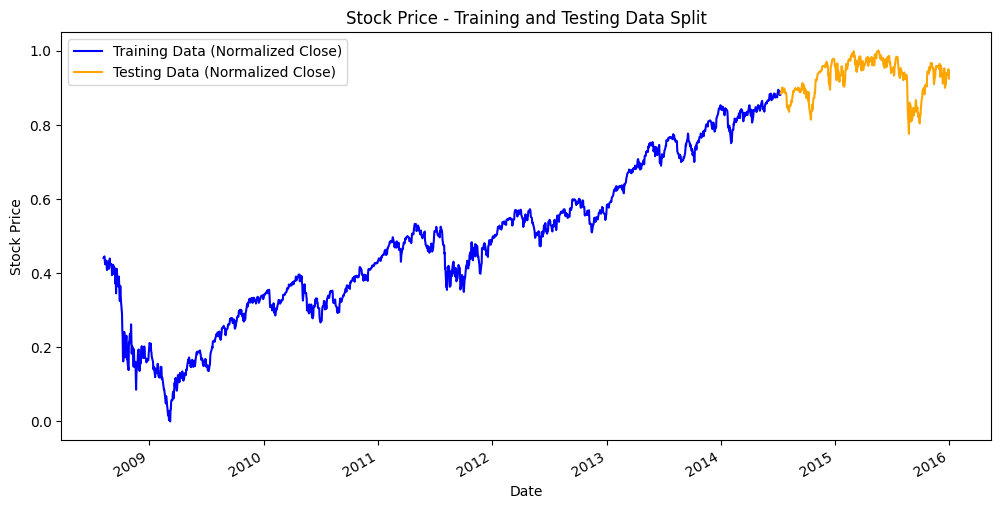

In [7]:
# Separate the original dataset into training and testing sets based on the split
train_data_len = len(X_train_with) + look_back  # Length of training data including look-back
train_dates = final_dataset['Date'][:train_data_len]  # Dates for the training set
test_dates = final_dataset['Date'][train_data_len:]   # Dates for the testing set

train = data_with_sentiment[:train_data_len]  # Training set
test = data_with_sentiment[train_data_len:]   # Testing set

# Plot the training and testing data with dates on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train[:, 0], label='Training Data (Normalized Close)', color='blue')
plt.plot(test_dates, test[:, 0], label='Testing Data (Normalized Close)', color='orange')

# Format the x-axis for better readability (optional)
plt.gcf().autofmt_xdate()

# Add labels and title
plt.title("Stock Price - Training and Testing Data Split")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# 4. Building the LSTM Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Model with Sentiment Score
print("Building LSTM model with sentiment score...")
model_with_sentiment = Sequential()

# Add LSTM and Dropout layers
model_with_sentiment.add(LSTM(50, return_sequences=True, input_shape=(X_train_with.shape[1], X_train_with.shape[2])))  # Input shape: (timesteps, features)
model_with_sentiment.add(Dropout(0.2))
model_with_sentiment.add(LSTM(50, return_sequences=False))
model_with_sentiment.add(Dropout(0.2))
model_with_sentiment.add(Dense(25))  # Dense layer with 25 neurons
model_with_sentiment.add(Dense(1))   # Output layer for the predicted 'Close' price

# Compile the model
model_with_sentiment.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model_with_sentiment.summary()

# Model without Sentiment Score
print("\nBuilding LSTM model without sentiment score...")
model_without_sentiment = Sequential()

# Add LSTM and Dropout layers
model_without_sentiment.add(LSTM(50, return_sequences=True, input_shape=(X_train_without.shape[1], 1)))  # Only one feature
model_without_sentiment.add(Dropout(0.2))
model_without_sentiment.add(LSTM(50, return_sequences=False))
model_without_sentiment.add(Dropout(0.2))
model_without_sentiment.add(Dense(25))  # Dense layer with 25 neurons
model_without_sentiment.add(Dense(1))   # Output layer for the predicted 'Close' price

# Compile the model
model_without_sentiment.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model_without_sentiment.summary()

Building LSTM model with sentiment score...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,101 (125.39 KB)

 Trainable params: 32,101 (125.39 KB)

 Non-trainable params: 0 (0.00 B)


Building LSTM model without sentiment score...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Training the LSTM model with sentiment score...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0358 - val_loss: 0.0034
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0029 - val_loss: 5.5911e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0022 - val_loss: 9.1717e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0019 - val_loss: 5.7007e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0015 - val_loss: 5.8175e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0012 - val_loss: 0.0011

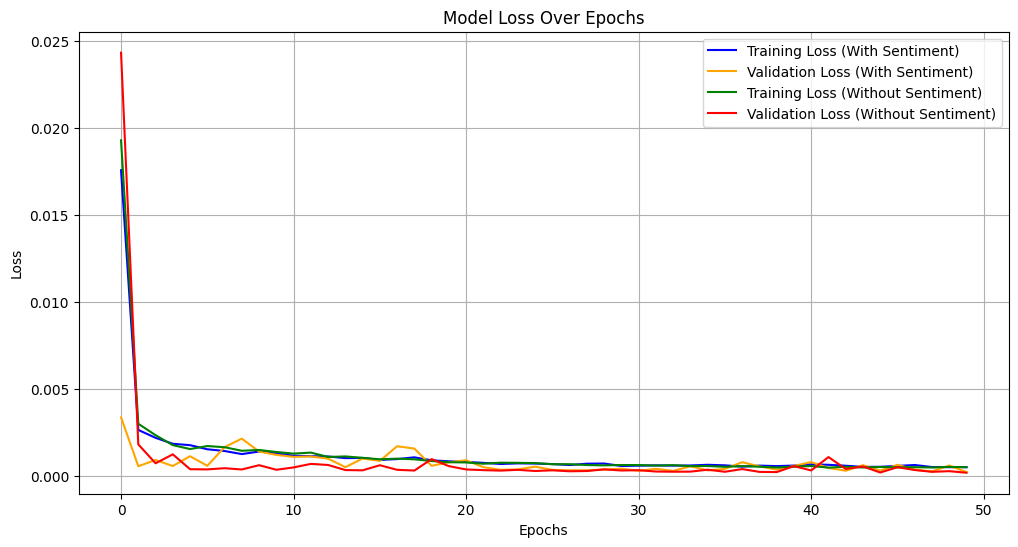

In [9]:
# Train the LSTM model with sentiment score
print("Training the LSTM model with sentiment score...")
history_with_sentiment = model_with_sentiment.fit(
    X_train_with,
    y_train_with,
    batch_size=32,
    epochs=50,
    validation_split=0.2
)

# Train the LSTM model without sentiment score
print("\nTraining the LSTM model without sentiment score...")
history_without_sentiment = model_without_sentiment.fit(
    X_train_without,
    y_train_without,
    batch_size=32,
    epochs=50,
    validation_split=0.2
)

# Plot training and validation loss for both models
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot loss for the model with sentiment score
plt.plot(history_with_sentiment.history['loss'], label='Training Loss (With Sentiment)', color='blue')
plt.plot(history_with_sentiment.history['val_loss'], label='Validation Loss (With Sentiment)', color='orange')

# Plot loss for the model without sentiment score
plt.plot(history_without_sentiment.history['loss'], label='Training Loss (Without Sentiment)', color='green')
plt.plot(history_without_sentiment.history['val_loss'], label='Validation Loss (Without Sentiment)', color='red')

# Add plot details
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 7. Plotting Predictions vs Actual Values

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# **Predictions for the Model with Sentiment Score**
print("\nEvaluating the model with sentiment score...")
train_predictions_with = model_with_sentiment.predict(X_train_with)
test_predictions_with = model_with_sentiment.predict(X_test_with)

# Inverse transform predictions and actual values
train_predictions_with_inv = scaler.inverse_transform(
    np.concatenate((train_predictions_with, np.zeros((train_predictions_with.shape[0], 1))), axis=1)
)[:, 0]

test_predictions_with_inv = scaler.inverse_transform(
    np.concatenate((test_predictions_with, np.zeros((test_predictions_with.shape[0], 1))), axis=1)
)[:, 0]

y_train_with_inv = scaler.inverse_transform(
    np.concatenate((y_train_with.reshape(-1, 1), np.zeros((y_train_with.shape[0], 1))), axis=1)
)[:, 0]

y_test_with_inv = scaler.inverse_transform(
    np.concatenate((y_test_with.reshape(-1, 1), np.zeros((y_test_with.shape[0], 1))), axis=1)
)[:, 0]

# Calculate RMSE and MAE for the model with sentiment score
train_rmse_with = sqrt(mean_squared_error(y_train_with_inv, train_predictions_with_inv))
test_rmse_with = sqrt(mean_squared_error(y_test_with_inv, test_predictions_with_inv))
train_mae_with = mean_absolute_error(y_train_with_inv, train_predictions_with_inv)
test_mae_with = mean_absolute_error(y_test_with_inv, test_predictions_with_inv)

print(f"Model with Sentiment - Train RMSE: {train_rmse_with}, Test RMSE: {test_rmse_with}")
print(f"Model with Sentiment - Train MAE: {train_mae_with}, Test MAE: {test_mae_with}")


# **Predictions for the Model without Sentiment Score**
print("\nEvaluating the model without sentiment score...")
train_predictions_without = model_without_sentiment.predict(X_train_without)
test_predictions_without = model_without_sentiment.predict(X_test_without)

# Inverse transform predictions and actual values
train_predictions_without_inv = scaler.inverse_transform(train_predictions_without)
test_predictions_without_inv = scaler.inverse_transform(test_predictions_without)
y_train_without_inv = scaler.inverse_transform(y_train_without.reshape(-1, 1))
y_test_without_inv = scaler.inverse_transform(y_test_without.reshape(-1, 1))

# Calculate RMSE and MAE for the model without sentiment score
train_rmse_without = sqrt(mean_squared_error(y_train_without_inv, train_predictions_without_inv))
test_rmse_without = sqrt(mean_squared_error(y_test_without_inv, test_predictions_without_inv))
train_mae_without = mean_absolute_error(y_train_without_inv, train_predictions_without_inv)
test_mae_without = mean_absolute_error(y_test_without_inv, test_predictions_without_inv)

print(f"Model without Sentiment - Train RMSE: {train_rmse_without}, Test RMSE: {test_rmse_without}")
print(f"Model without Sentiment - Train MAE: {train_mae_without}, Test MAE: {test_mae_without}")


Evaluating the model with sentiment score...
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Model with Sentiment - Train RMSE: 0.017150692038089794, Test RMSE: 0.02125959587116352
Model with Sentiment - Train MAE: 0.012740436710277615, Test MAE: 0.016344634163041938

Evaluating the model without sentiment score...
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Model without Sentiment - Train RMSE: 0.016831585556829863, Test RMSE: 0.01998841332672856
Model without Sentiment - Train MAE: 0.012370032037975496, Test MAE: 0.015163555824501218


# 7. Plotting Predictions vs Actual Values

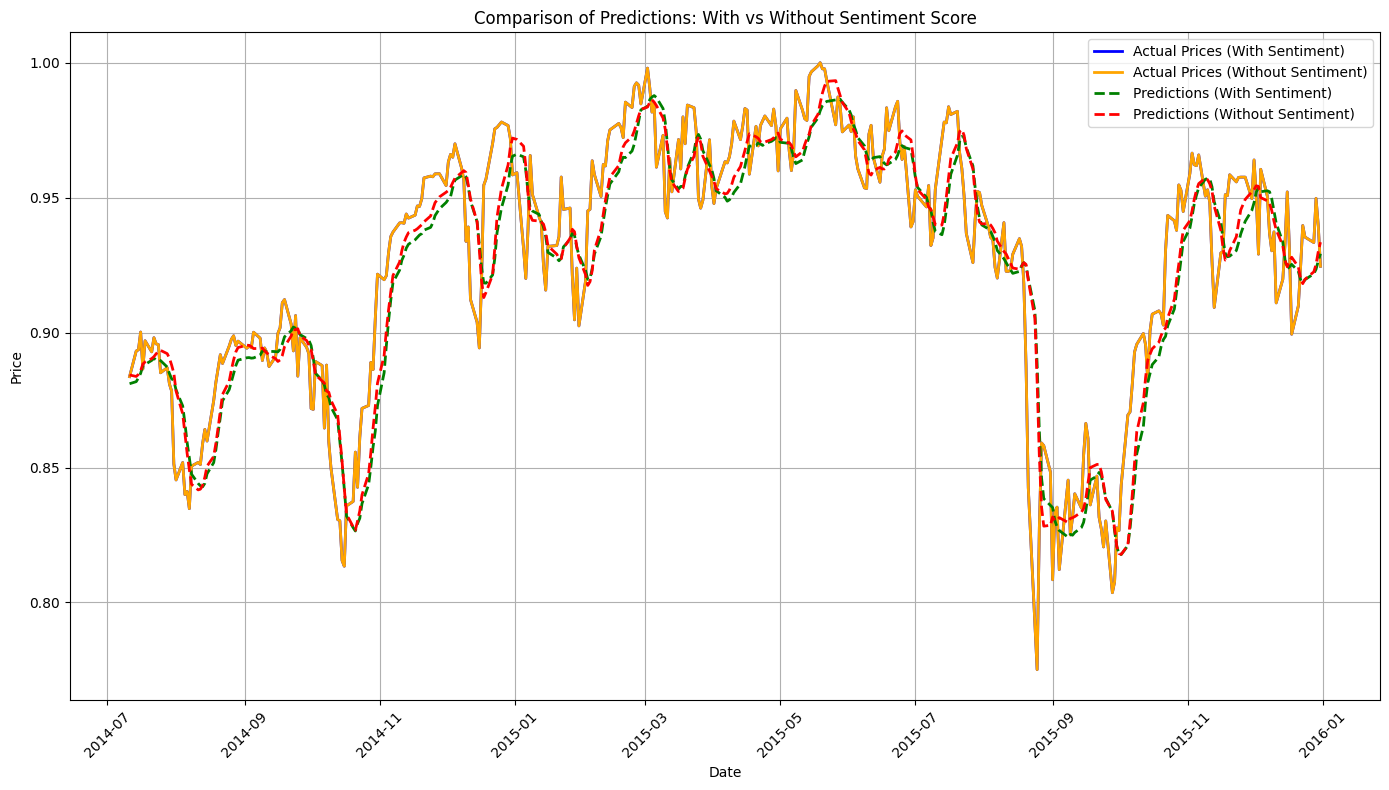

In [13]:
import matplotlib.pyplot as plt

# Ensure the lengths of predictions and actual values match
assert len(test_predictions_with_inv) == len(y_test_with_inv), "Mismatch in length of test predictions (with sentiment) and actual values."
assert len(test_predictions_without_inv) == len(y_test_without_inv), "Mismatch in length of test predictions (without sentiment) and actual values."

# Define test dates for predictions with and without sentiment
test_dates_with = dates[-len(y_test_with_inv):]  # Test dates aligned with sentiment model
test_dates_without = dates[-len(y_test_without_inv):]  # Test dates aligned without sentiment model

# Plot the data
plt.figure(figsize=(14, 8))

# Plot actual prices (with sentiment)
plt.plot(
    test_dates_with,
    y_test_with_inv,
    label='Actual Prices (With Sentiment)', color='blue', linewidth=2
)

# Plot actual prices (without sentiment)
plt.plot(
    test_dates_without,
    y_test_without_inv,
    label='Actual Prices (Without Sentiment)', color='orange', linewidth=2
)

# Plot predictions (with sentiment)
plt.plot(
    test_dates_with,
    test_predictions_with_inv,
    label='Predictions (With Sentiment)', color='green', linestyle='--', linewidth=2
)

# Plot predictions (without sentiment)
plt.plot(
    test_dates_without,
    test_predictions_without_inv,
    label='Predictions (Without Sentiment)', color='red', linestyle='--', linewidth=2
)

# Add plot details
plt.title('Comparison of Predictions: With vs Without Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()       # Adjust layout to fit all elements
plt.show()